In [16]:
from imgtools.io import read_dicom_series
from readii.loaders import loadSegmentation
from readii.image_processing import *
from readii.negative_controls import randomizeImageFromDistributionSampling, applyNegativeControl

In [2]:
baseImage = read_dicom_series("../tests/NSCLC_Radiogenomics/R01-001/09-06-1990-NA-CT_CHEST_ABD_PELVIS_WITH_CON-98785/3.000000-THORAX_1.0_B45f-95741")

segImages = loadSegmentation("../tests/NSCLC_Radiogenomics/R01-001/09-06-1990-NA-CT_CHEST_ABD_PELVIS_WITH_CON-98785/1000.000000-3D_Slicer_segmentation_result-67652/1-1.dcm",
                            modality = 'SEG')
roiImage = segImages['Heart']
flattenedROIImage = flattenImage(roiImage)
baseROI = alignImages(baseImage, flattenedROIImage)

roiLabel = getROIVoxelLabel(baseROI)

randomSeed = 10

In [27]:
ctDirPath = "/Users/katyscott/Documents/HNC Project/data/error_images/RADCURE/RADCURE-2012/12-26-2001-NA-Research HNC Planning CT-39063/3.000000-Helical Axial-26282"
segFilePath = "/Users/katyscott/Documents/HNC Project/data/error_images/RADCURE/RADCURE-2012/12-26-2001-NA-Research HNC Planning CT-39063/1.000000-NA-03155/1-1.dcm"

baseImage = read_dicom_series(ctDirPath)
segImages = loadSegmentation(segFilePath, "RTSTRUCT", ctDirPath, roiNames="GTVp.*")

roiImage = segImages["GTVp"]
baseROI = alignImages(baseImage, roiImage)

labels: {'GTVp': 0}


In [29]:
# convert CT to array
arrBaseImage = sitk.GetArrayFromImage(baseImage)

# convert baseROI to array
arrBaseROI = sitk.GetArrayFromImage(baseROI)

# make binary mask out of ROI (NaN for background, 1 for ROI)
binBaseROI = np.where(arrBaseROI > 0, 1, np.NaN)

# multiply the mask by the CT to get just ROI voxels
roiMaskedBaseImage = arrBaseImage * binBaseROI

In [28]:
maxROIVoxelVal = int(np.nanmax(roiMaskedBaseImage))
minROIVoxelVal = int(np.nanmin(roiMaskedBaseImage))

In [30]:
arrNewBaseImage = arrBaseImage.copy()

In [4]:
randomSampledImage = randomizeImageFromDistributionSampling(baseImage, randomSeed)

In [8]:
arrRandomSampledImage = sitk.GetArrayFromImage(randomSampledImage)

# Make ROI voxels 0 to multiple by the full negative control image
inverseBinMask = np.where(arrBaseROI > 0, 0, 1)

# Multiple random sampled image by 0s where the ROI is
roiMaskedRndSamImage = inverseBinMask * arrRandomSampledImage

# Then add 


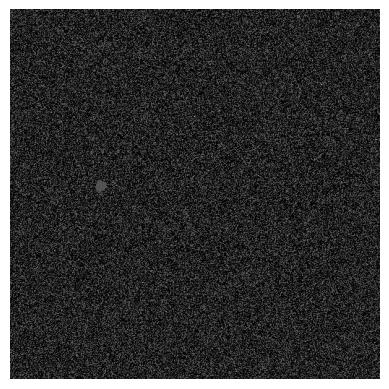

In [13]:
from readii.image_processing import *

displayCTSegOverlay(roiMaskedRndSamImage, baseROI, 240, alpha = 0)

In [30]:
np.nonzero(arrBaseROI)

(array([106, 106, 106, ..., 141, 141, 141]),
 array([174, 174, 174, ..., 200, 200, 200]),
 array([249, 250, 251, ..., 270, 271, 272]))

In [ ]:
# get count of non NaN values
# generate that many random values using max and min
# somehow get them into the correct shape of the ROI?

# or get size of ROI bounds
# make random array that size and multiply

In [18]:
def negativeControlROIOnly(baseImage, roiMask, negativeControlType, randomSeed):
    negativeControlName = negativeControlType + "_full"

    # Get desired negative control of baseImage
    ncBaseImage = applyNegativeControl(nc_type = negativeControlName,
                                       baseImage = baseImage,
                                       randomSeed = randomSeed)

    # Convert images to arrays
    arrBaseImage = sitk.GetArrayFromImage(baseImage)
    arrROIMask = sitk.GetArrayFromImage(roiMask)
    arrNCBaseImage = sitk.GetArrayFromImage(ncBaseImage)

    # Get binary segmentation masks
    # ROI is 1, background is 0
    binROIMask = np.where(arrROIMask > 0, 1, 0)
    # ROI is 0, background is 1
    inverseBinROIMask = np.where(arrROIMask > 0, 0, 1)

    arrNCROIImage = (arrNCBaseImage * binROIMask) + (arrBaseImage * inverseBinROIMask)

    ncROIImage = sitk.GetImageFromArray(arrNCROIImage)

    alignedNCROIImage = alignImages(baseImage, ncROIImage)

    return alignedNCROIImage


In [23]:
def negativeControlNonROIOnly(baseImage, roiMask, negativeControlType, randomSeed):
    negativeControlName = negativeControlType + "_full"

    # Get desired negative control of baseImage
    ncBaseImage = applyNegativeControl(nc_type = negativeControlName,
                                       baseImage = baseImage,
                                       randomSeed = randomSeed)

    # Convert images to arrays
    arrBaseImage = sitk.GetArrayFromImage(baseImage)
    arrROIMask = sitk.GetArrayFromImage(roiMask)
    arrNCBaseImage = sitk.GetArrayFromImage(ncBaseImage)

    # Get binary segmentation masks
    # ROI is 1, background is 0
    binROIMask = np.where(arrROIMask > 0, 1, 0)
    # ROI is 0, background is 1
    inverseBinROIMask = np.where(arrROIMask > 0, 0, 1)

    arrNCNonROIImage = (arrNCBaseImage * inverseBinROIMask) + (arrBaseImage * binROIMask)

    ncNonROIImage = sitk.GetImageFromArray(arrNCNonROIImage)

    alignedNCNonROIImage = alignImages(baseImage, ncNonROIImage)

    return alignedNCNonROIImage


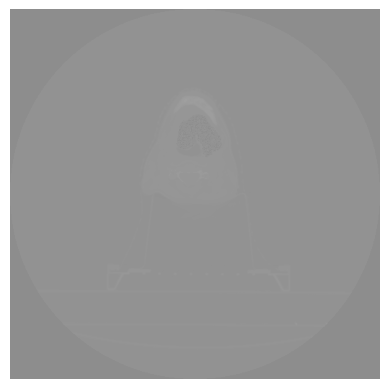

In [32]:
ncROIImage = negativeControlROIOnly(baseImage, baseROI, negativeControlType = "randomized_sampled", randomSeed = 10)
displayImageSlice(ncROIImage, 120)

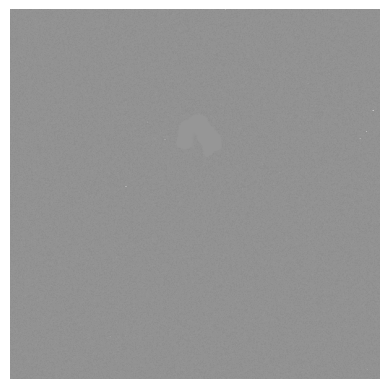

In [31]:
ncNonROIImage = negativeControlNonROIOnly(baseImage, baseROI, negativeControlType = "randomized_sampled", randomSeed = 10)
displayImageSlice(ncNonROIImage, 120)